## Meridional Overturning Circulation

In [1]:
%%capture 
# comment above line to see details about the run(s) displayed
from misc import *
%matplotlib inline

In [2]:
ds = []
for c, l, p in zip(casename,label, ocn_path):
  dummy = xr.open_dataset(p+'{}_MOC.nc'.format(c))
  ds.append(dummy) 

### Global MOC

In [3]:
# Global MOC
from  mom6_tools import m6plot, m6toolbox
from mom6_tools.moc import  *
import glob

In [4]:
fnames = ['*.mom6.h.z.????-??.nc','*.mom6.h.z.????-??.nc','*.mom6.h.z.????-??.nc',
         '*.mom6.h.z.????-??.nc']

In [5]:
pnum = len(ds)
varName = 'vmo'
Zmod = []
fnames
for i, f in zip(range(pnum),fnames):
  # this hack needs to be fixed
  print(OUTDIR[i]+f)
  file = sorted(glob.glob(OUTDIR[i]+f))[0:2]
  ds1 = xr.open_mfdataset(file)
  Zmod.append(m6toolbox.get_z(ds1, depth[i], varName))

/glade/derecho/scratch/gmarques/archive/g.e23_a16g.GJRAv4.TL319_t232_hycom1_N75.2024.016/ocn/hist/*.mom6.h.z.????-??.nc


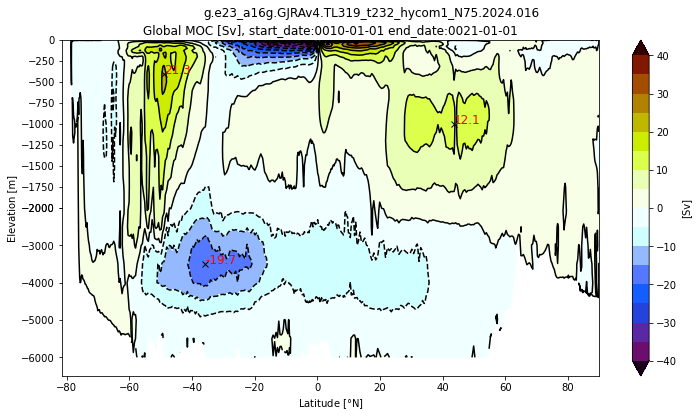

In [6]:
for i in range(pnum):
  m6plot.setFigureSize([16,9],576,debug=False)
  axis = plt.gca()
  cmap = plt.get_cmap('dunnePM')
  zg = Zmod[i].min(axis=-1); 
  psiPlot = ds[i].moc.values
  yyg = grd[i].geolat_c[:,:].max(axis=-1)+0*zg

  ci=m6plot.pmCI(0.,40.,5.)
  plotPsi(yyg, zg, psiPlot, ci, 'Global MOC [Sv], ' + \
         'start_date:' + ds[i].start_date +' end_date:' + ds[i].end_date)
  plt.xlabel(r'Latitude [$\degree$N]')
  plt.suptitle(casename[i])

  findExtrema(yyg, zg, psiPlot, max_lat=-30.)
  findExtrema(yyg, zg, psiPlot, min_lat=25., min_depth=250.)
  findExtrema(yyg, zg, psiPlot, min_depth=2000., mult=-1.)
  plt.gca().invert_yaxis()


### Atlantic MOC

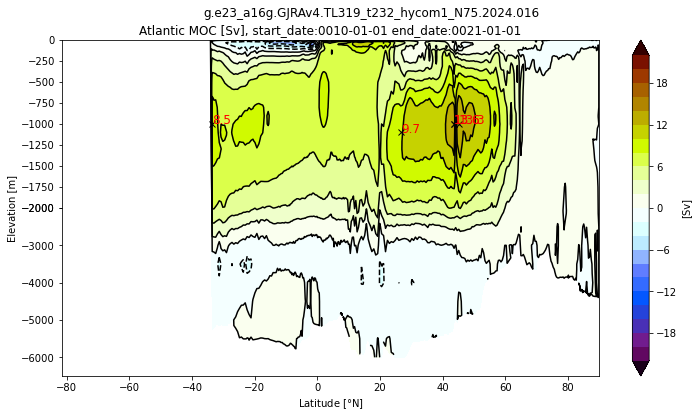

In [7]:
for i in range(pnum):
  basin_code = genBasinMasks(grd[i].geolon, grd[i].geolat, depth[i], xda=False);
  m6plot.setFigureSize([16,9],576,debug=False)
  cmap = plt.get_cmap('dunnePM')
  ci=m6plot.pmCI(0.,22.,2.)
  m = 0*basin_code; m[(basin_code==2) | (basin_code==4) | (basin_code==6) | (basin_code==7) | (basin_code==8)]=1
  z = (m*Zmod[i]).min(axis=-1)
  psiPlot = ds[i].amoc.values
  yy = grd[i].geolat_c[:,:].max(axis=-1)+0*z
  plotPsi(yy, z, psiPlot, ci, 'Atlantic MOC [Sv], ' + \
         'start_date:' + ds[i].start_date +' end_date:' + ds[i].end_date)
  plt.xlabel(r'Latitude [$\degree$N]')
  plt.suptitle(casename[i])
  findExtrema(yy, z, psiPlot, min_lat=26.5, max_lat=27., min_depth=250.) # RAPID
  findExtrema(yy, z, psiPlot, min_lat=44, max_lat=46., min_depth=250.) # RAPID
  findExtrema(yy, z, psiPlot, max_lat=-33.)
  findExtrema(yy, z, psiPlot)
  findExtrema(yy, z, psiPlot, min_lat=5.)
  plt.gca().invert_yaxis()

### AMOC profile at 26N

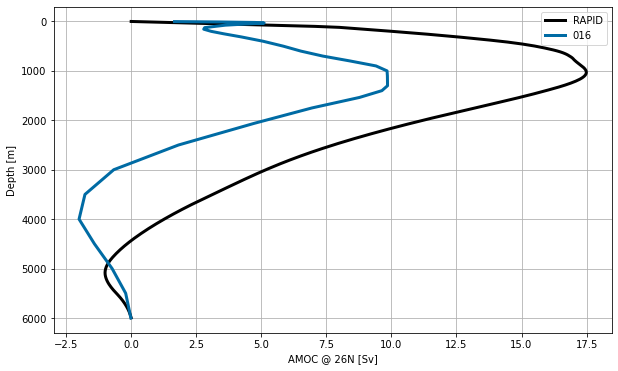

In [8]:
fig, ax = plt.subplots(figsize=(10,6))
rapid_vertical = xr.open_dataset('/glade/work/gmarques/cesm/datasets/RAPID/moc_vertical.nc')
ax.plot(rapid_vertical.stream_function_mar.mean('time'),
        rapid_vertical.depth, 'k', label='RAPID', lw=3)
for i in range(pnum):
  ax.plot(ds[i]['amoc'].sel(yq=26, method='nearest'), ds[i].zl, label=label[i], lw=3)

ax.legend()
plt.gca().invert_yaxis()
plt.grid()
ax.set_xlabel('AMOC @ 26N [Sv]')
ax.set_ylabel('Depth [m]');

### AMOC time series

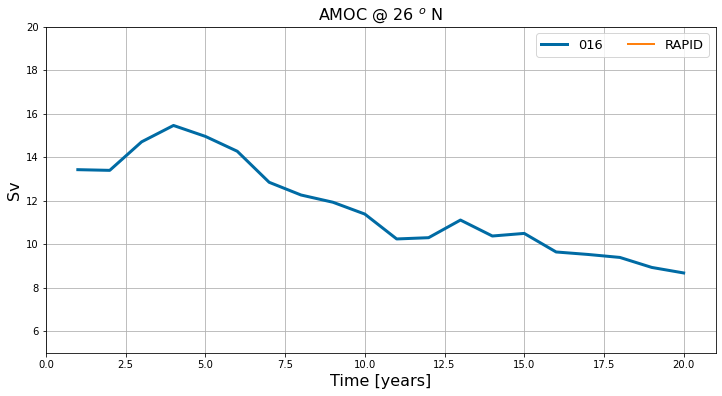

In [9]:
# load RAPID time series
rapid = xr.open_dataset('/glade/work/gmarques/cesm/datasets/RAPID/moc_transports.nc').resample(time="1Y", 
                            closed='left',keep_attrs=True).mean('time',keep_attrs=True)

# plot
fig = plt.figure(figsize=(12, 6))
for i in range(pnum):
  plt.plot(np.arange(len(ds[i].time))+1. ,ds[i]['amoc_26'].values, 
           label=label[i], lw=3)
# rapid
plt.plot(np.arange(len(rapid.time))+46.5 ,rapid.moc_mar_hc10.values, 
         label='RAPID', lw=2)

plt.title('AMOC @ 26 $^o$ N', fontsize=16)
plt.ylim(5,20)
plt.xlim(0,1+len(ds[0].time))
plt.xlabel('Time [years]', fontsize=16); plt.ylabel('Sv', fontsize=16)
plt.legend(fontsize=13, ncol=2)
plt.grid()

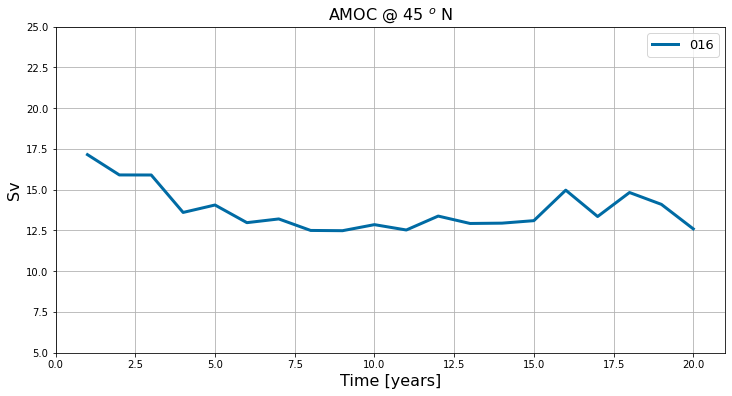

In [10]:
# plot
fig = plt.figure(figsize=(12, 6))
for i in range(pnum):
  plt.plot(np.arange(len(ds[i].time))+1 ,ds[i]['amoc_45'].values, 
           label=label[i], lw=3)
plt.title('AMOC @ 45 $^o$ N', fontsize=16)
plt.ylim(5,25)
plt.xlim(0,1+len(ds[0].time))
plt.xlabel('Time [years]', fontsize=16); plt.ylabel('Sv', fontsize=16)
plt.legend(fontsize=13, ncol=2);
plt.grid()

### Submesoscale-induced Global MOC

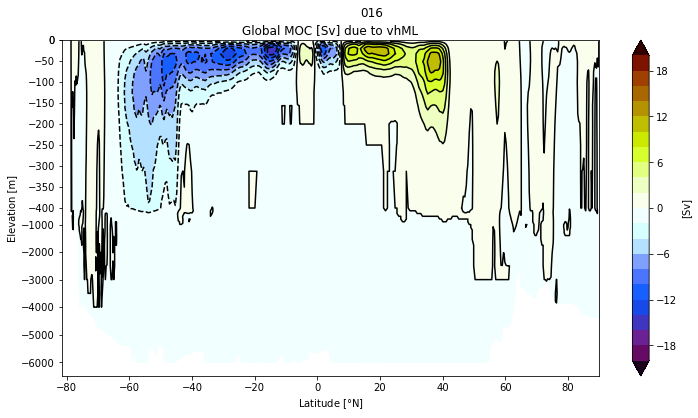

In [11]:
for i in range(pnum):
    # create a ndarray subclass
    class C(np.ndarray): pass
    varName = 'moc_FFM'

    psiPlot = np.ma.masked_invalid(ds[i][varName].values)
    tmp = psiPlot[:].filled(0.)
    VHmod = tmp.view(C)
    VHmod.units = 'Sv'

    # Global MOC
    m6plot.setFigureSize([16,9],576,debug=False)
    axis = plt.gca()
    cmap = plt.get_cmap('dunnePM')
    z =  Zmod[i].min(axis=-1) 
    #yy = y[1:,:].max(axis=-1)+0*z
    yy = grd[i].geolat_c[:,:].max(axis=-1)+0*z
    ci=m6plot.pmCI(0.,20.,2.)
    plotPsi(yy, z, psiPlot, ci, 'Global MOC [Sv] due to vhML', zval=[0.,-400.,-6500.])
    plt.xlabel(r'Latitude [$\degree$N]')
    plt.suptitle(label[i])
    plt.gca().invert_yaxis()

### Eddy(GM)-induced Global MOC

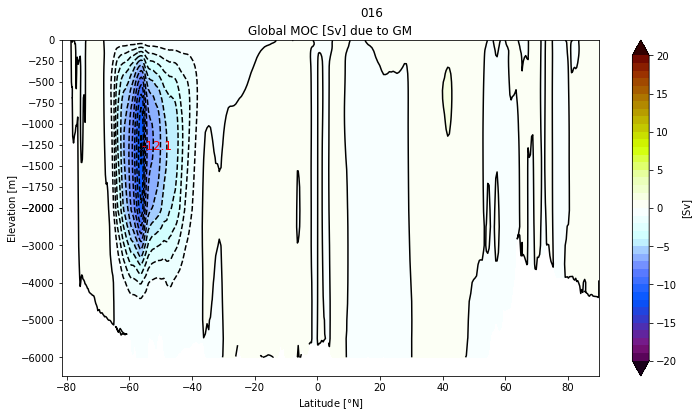

In [12]:
for i in range(pnum):
    # create a ndarray subclass
    class C(np.ndarray): pass
    varName = 'moc_GM'

    psiPlot = np.ma.masked_invalid(ds[i][varName].values)
    tmp = psiPlot[:].filled(0.)
    VHmod = tmp.view(C)
    VHmod.units = 'Sv'

    # Global MOC
    m6plot.setFigureSize([16,9],576,debug=False)
    axis = plt.gca()
    cmap = plt.get_cmap('dunnePM')
    z =  Zmod[i].min(axis=-1) 
    yy = grd[0].geolat_c[:,:].max(axis=-1)+0*z
    ci=m6plot.pmCI(0.,20.,1.)
    plotPsi(yy, z, psiPlot, ci, 'Global MOC [Sv] due to GM')
    plt.xlabel(r'Latitude [$\degree$N]')
    plt.suptitle(label[i])
    findExtrema(yy, z, psiPlot, min_lat=-65., max_lat=-30, mult=-1.)
    plt.gca().invert_yaxis()